In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install ip2geotools
from ip2geotools.databases.noncommercial import DbIpCity
from geopy.distance import distance
import urllib.request
!pip install --pre scapy[basic]
from scapy.all import *
import socket

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [ ]:
servers_df = pd.read_excel('servers.xlsx')
servers_df.head() #to see head of our data

,URL,City
0,ftp.it.debian.org,Italy
1,debian.dynamica.it,Italy
2,debian.mirror.garr.it,Italy
3,ftp.linux.it,Italy
4,debian-mirror.sakura.ne.jp,japan


In [ ]:
RTT = []
for i in range(0, len(servers_df['URL'])): #in this loop we try to get each server and calculate the RTT
  target = servers_df['URL'][i]
  pck = IP(dst=target)/ICMP()
  ans, unans = sr(pck, timeout=5, verbose=False)
  try:
    RTT.append(round((ans[0][1].time - ans[0][0].sent_time)*1000,2)) #add the RTT to our dataframe
    #print(RTT[i])
  except:
    print('ERROR', servers_df['City'][i])

In [ ]:
servers_df['RTT'] = RTT

In [ ]:
def find_distancebetween_two_ip(ip1, ip2):
  #this func will find the distance between two ips
  res1 = DbIpCity.get(ip1)
  res2 = DbIpCity.get(ip2)
  lat1, lon1 = res1.latitude, res1.longitude
  lat2, lon2 = res2.latitude, res2.longitude
  return distance((lat1, lon1), (lat2, lon2)).km

Distance = []
api='https://api.ipify.org'
my_ip = urllib.request.urlopen(api).read().decode('UTF-8')
#I store my ip in my_ip variable to be able to calculate my distance between my ip and the other servers ip
#Input two IP addresses
for i in servers_df['URL']:
  ip_add_1 = my_ip
  ip_add_2 = socket.gethostbyname(i)
  Distance.append(round(find_distancebetween_two_ip(ip_add_1, ip_add_2),2))
  #print(f"Distance between them is {str(Distance)}km")

servers_df['Distance'] = Distance

In [ ]:
servers_df.head()
#check the head of my df to see everything is right

,URL,City,RTT,Distance
0,ftp.it.debian.org,Italy,105.15,6809.87
1,debian.dynamica.it,Italy,96.00,6809.87
2,debian.mirror.garr.it,Italy,112.15,7235.03
3,ftp.linux.it,Italy,104.69,6809.87
4,debian-mirror.sakura.ne.jp,japan,163.08,11197.13


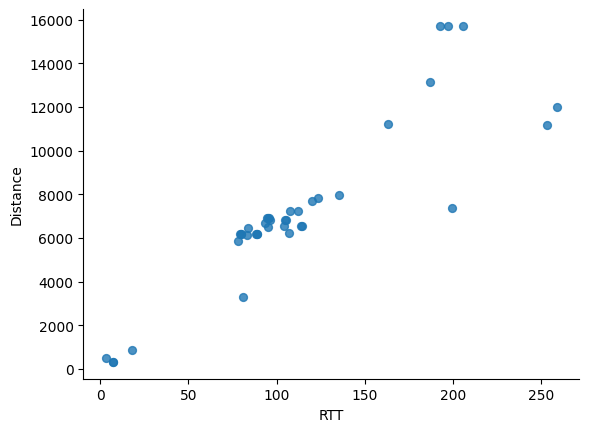

In [ ]:
servers_df.plot(kind='scatter', x='RTT', y='Distance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Distance', ylabel='RTT'>

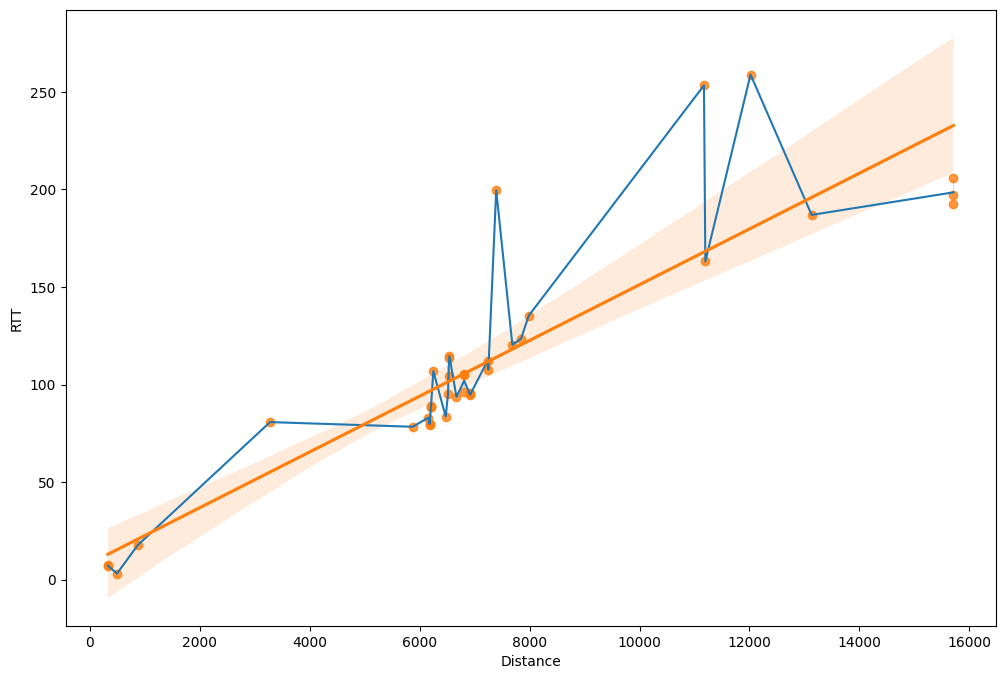

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=servers_df, x='Distance', y='RTT')
sns.regplot(data=servers_df, x='Distance', y='RTT')

In [ ]:
coefficients = np.polyfit(servers_df['Distance'], servers_df['RTT'], 1)

In [ ]:
estimated_rtt = np.polyval(coefficients, servers_df['Distance'])

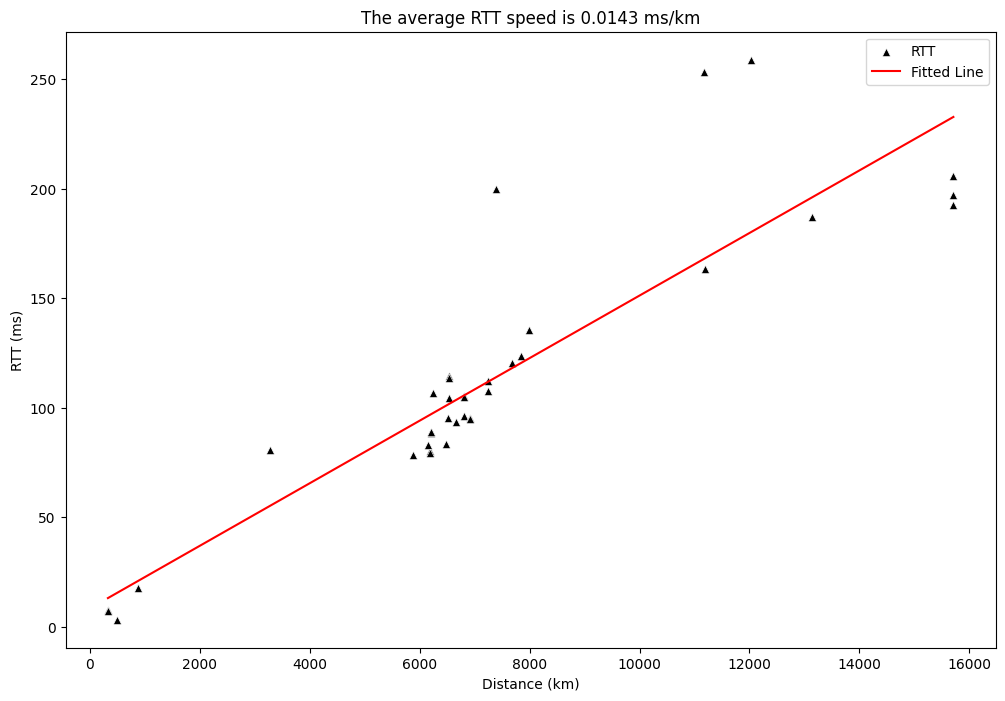

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=servers_df, x='Distance', y='RTT',label='RTT', color='black', marker='^')
sns.lineplot( x=servers_df['Distance'], y=estimated_rtt, color='red', label='Fitted Line')
plt.xlabel('Distance (km)')
plt.ylabel('RTT (ms)')
plt.title(f'The average RTT speed is {round(coefficients[0],4)} ms/km')
#the slope of our line is the speed, the slope is stored in coefficients[0]
plt.show()

the slope of our line is the speed, the slope is stored in coefficients[0], so the avg speed is 0.0143 ms/km